In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import copy
import csv



print("imported modules")

imported modules


In [42]:
# configuration
start_post = 0
end_post = 10000

In [3]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


In [ ]:
def get_date(data_string):
    date = datetime.date(datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S'))
    year = pd.Timestamp(date).year
    quarter = pd.Timestamp(date).quarter
    return year, quarter

def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

In [67]:
def vectorizer_with_threshold(text_vectorizer):
    threshold = 0.3
    vec = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= threshold]
    return vec

def vectorizer_top_n_words(text_vectorizer):    
    n = 3
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]        
    return vec


def vectorizer_top_n_percent(text_vectorizer, vec_len):
    percent = 0.15
    #vec_len = len(vectorizer.get_feature_names())
    n = int(vec_len * percent)
    
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]            
    return vec

In [69]:
def get_relevant_words(text):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.5)
    try:
        text_vectorizer = vectorizer.fit_transform([text])
    except:        
        return False
    relevant_words = []    
    feature_array = np.array(vectorizer.get_feature_names())

    #tfidf_bigger_than = vectorizer_with_threshold(text_vectorizer)
    #tfidf_bigger_than = vectorizer_with_n_words(text_vectorizer)
    tfidf_bigger_than = vectorizer_top_n_percent(text_vectorizer, len(feature_array))
    relevant_words.append(feature_array[tfidf_bigger_than])
    return relevant_words
    
def add_words_to_counter(relevant_words, filtered_spans):    
    for word in relevant_words[0]:          
        for span in filtered_spans:            
            if word in span.text:    
                topic_counter[span.lemma_] += 1

In [70]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'POS': 'NOUN', 'OP': '+'},
           {'POS': 'NOUN', 'OP': '?'}
          ]


word_set = set()
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'

matcher.add("match_topic1", [topic_pattern1])

questions_df = pd.DataFrame(stack_posts[start_post:end_post])
questions_df = questions_df.drop_duplicates(["QuestionId"])

topic_counter = Counter()

for question in questions_df["QuestionBody"][start_post:end_post]:
    text = re.sub(regex_pattern, '', question, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)    
    
    doc = nlp(text)    
    
    matches = matcher(doc)
    
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = filter_spans(span_list)    
        
    relevant_words = get_relevant_words(text)
    if relevant_words == False:
        continue    
    add_words_to_counter(relevant_words, filtered_spans)                
    
                
print("finished questions")
for answer in stack_posts["AnswerBody"][start_post:end_post]:
    text = re.sub(regex_pattern, '', answer, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)    
    
    doc = nlp(text)    
    
    matches = matcher(doc)
    
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = filter_spans(span_list)
    
    relevant_words = get_relevant_words(text)
    if relevant_words == False:
        continue
    add_words_to_counter(relevant_words, filtered_spans)         

print("finished answers")

finished questions
finished answers


In [33]:
bigger_than_x_counter = Counter({k: c for k,c in topic_counter.items() if c >= 50})
sorted_counter = bigger_than_x_counter.most_common()
df = pd.DataFrame.from_dict(bigger_than_x_counter, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False)

plt.style.use('fivethirtyeight')

figure = df.plot(kind = 'bar', figsize=(25, 25))
figure.set_xlabel("Wort")
figure.set_ylabel("Häufigkeit")

TypeError: no numeric data to plot

In [ ]:
Counter({k: c/topic_counter_sum*100 for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True)})

In [ ]:
relative_counter

<BarContainer object of 98 artists>

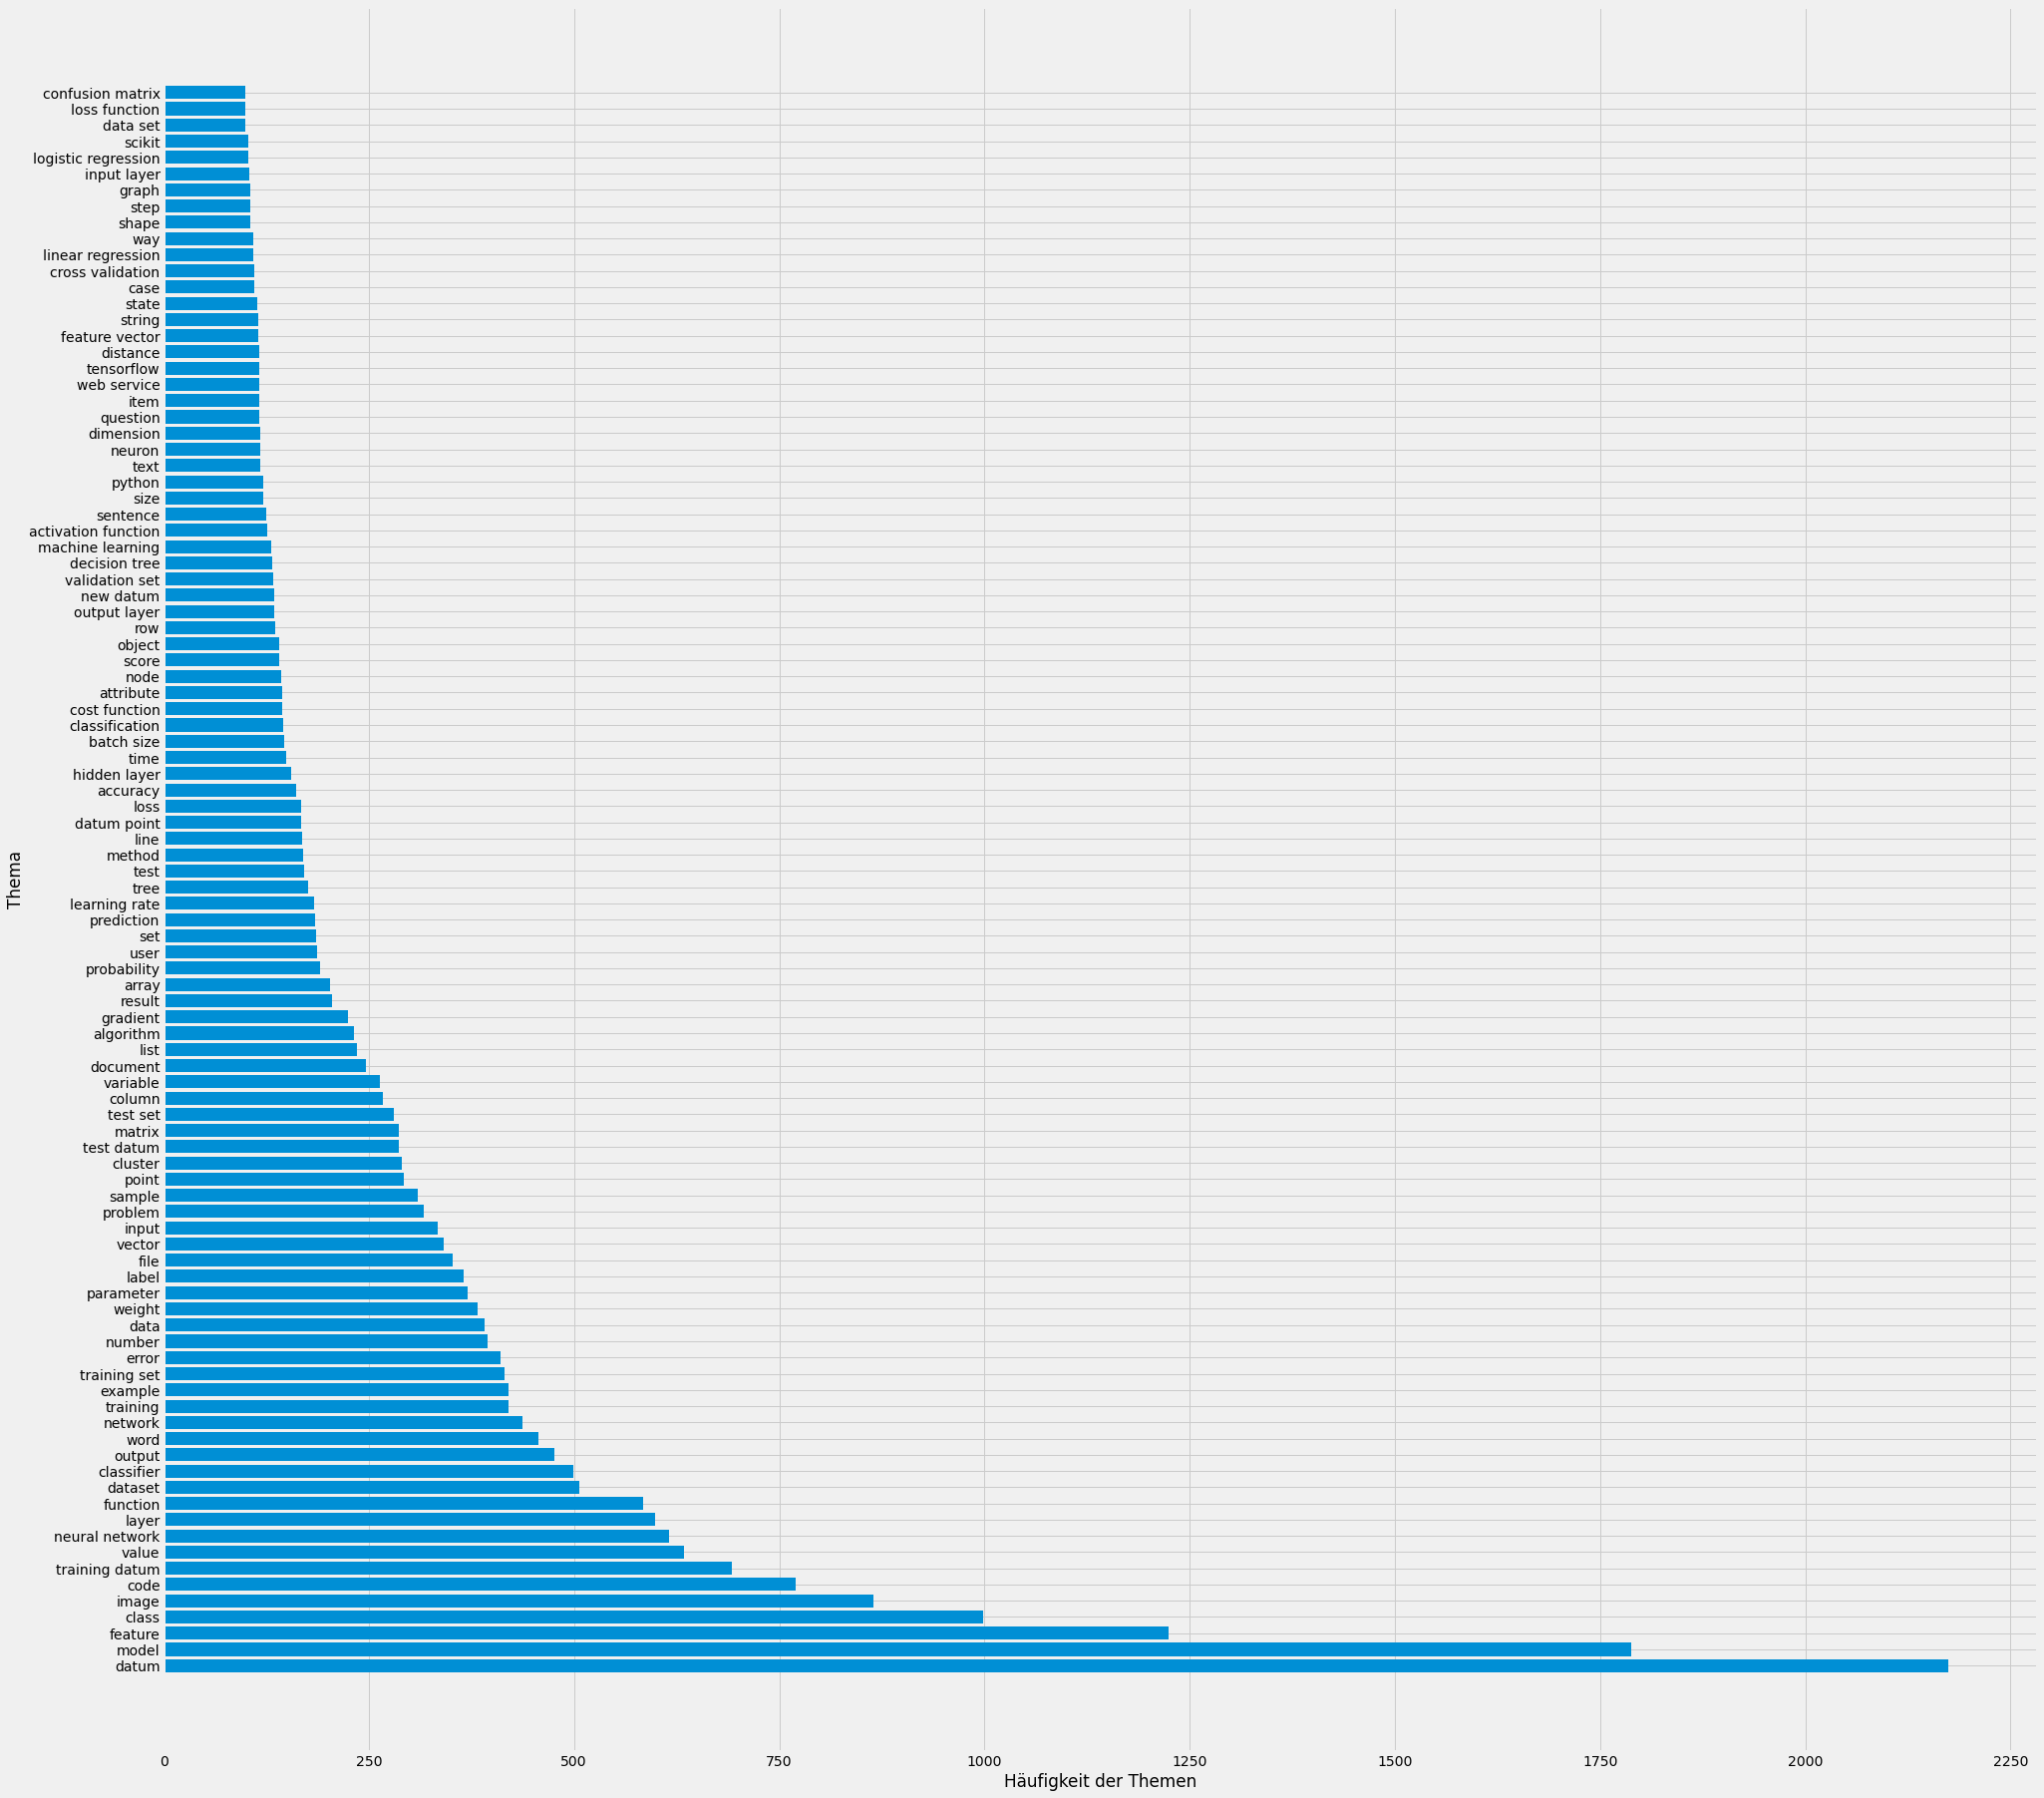

In [59]:
# vectorizer with threshold
bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True) if c >= 100})

keys = list(bigger_than_x_counter.keys())
values = bigger_than_x_counter.values()

fig, ax = plt.subplots(figsize=(30,30))
plt.xticks(np.arange(0, max(values)+250, 250.0))
#ax.xaxis.tick_top()
plt.xlabel('Häufigkeit der Themen')
plt.ylabel('Thema')
ax.barh(keys, values)

<BarContainer object of 177 artists>

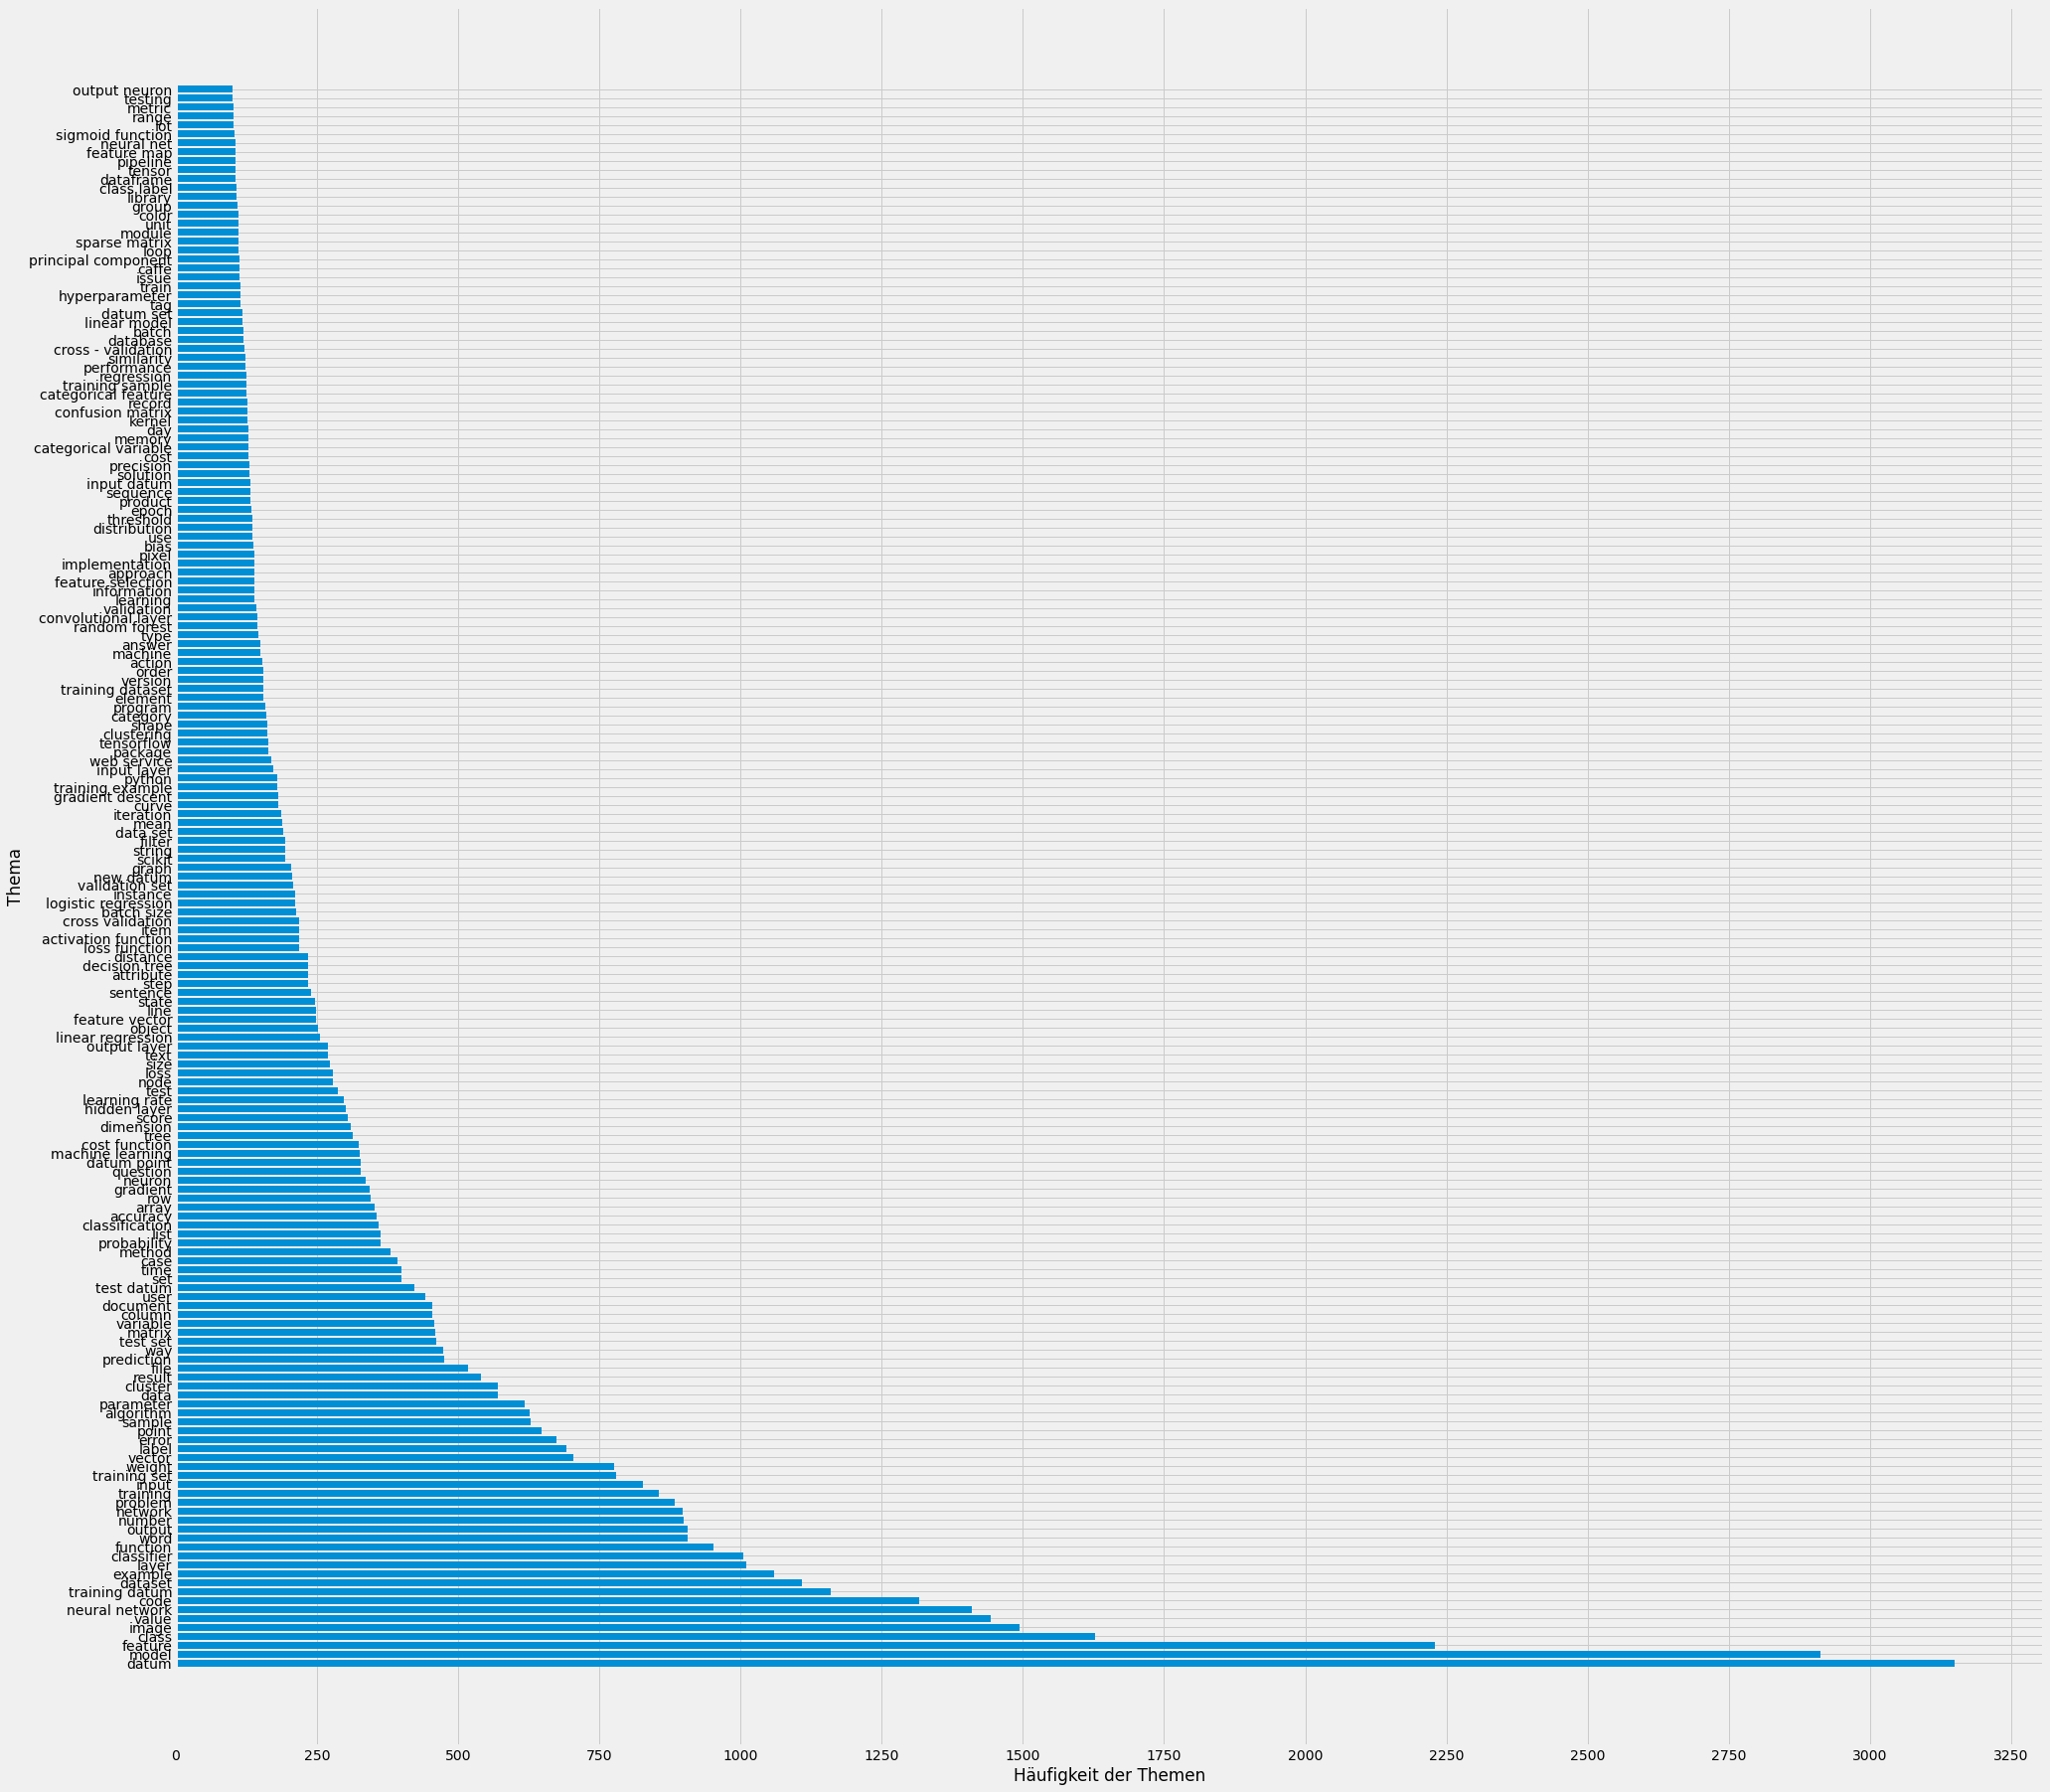

In [71]:
# vectorizer with percent
bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=True) if c >= 100})

keys = list(bigger_than_x_counter.keys())
values = bigger_than_x_counter.values()

fig, ax = plt.subplots(figsize=(30,30))
plt.xticks(np.arange(0, max(values)+250, 250.0))
#ax.xaxis.tick_top()
plt.xlabel('Häufigkeit der Themen')
plt.ylabel('Thema')
ax.barh(keys, values)
